<a href="https://colab.research.google.com/github/jeonghoya/Machine-Learning-Programming/blob/main/week9/alchol_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [30]:
# URL에서 CSV 데이터 로드
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/Alcohol_Sales.csv"
df = pd.read_csv(url, parse_dates=['DATE'], index_col='DATE')
data_raw = df['S4248SM144NCEN'].values.astype(float)
data_raw

array([ 3459.,  3458.,  4002.,  4564.,  4221.,  4529.,  4466.,  4137.,
        4126.,  4259.,  4240.,  4936.,  3031.,  3261.,  4160.,  4377.,
        4307.,  4696.,  4458.,  4457.,  4364.,  4236.,  4500.,  4974.,
        3075.,  3377.,  4443.,  4261.,  4460.,  4985.,  4324.,  4719.,
        4374.,  4248.,  4784.,  4971.,  3370.,  3484.,  4269.,  3994.,
        4715.,  4974.,  4223.,  5000.,  4235.,  4554.,  4851.,  4826.,
        3699.,  3983.,  4262.,  4619.,  5219.,  4836.,  4941.,  5062.,
        4365.,  5012.,  4850.,  5097.,  3758.,  3825.,  4454.,  4635.,
        5210.,  5057.,  5231.,  5034.,  4970.,  5342.,  4831.,  5965.,
        3796.,  4019.,  4898.,  5090.,  5237.,  5447.,  5435.,  5107.,
        5515.,  5583.,  5346.,  6286.,  4032.,  4435.,  5479.,  5483.,
        5587.,  6176.,  5621.,  5889.,  5828.,  5849.,  6180.,  6771.,
        4243.,  4952.,  6008.,  5353.,  6435.,  6673.,  5636.,  6630.,
        5887.,  6322.,  6520.,  6678.,  5082.,  5216.,  5893.,  5894.,
      

In [31]:
# -------------------------------------
# 2. Train / Test 분리 및 스케일링
# -------------------------------------

# 시계열 데이터이므로 순서를 유지한 채 분리
# 8:2 비율로 분리
split_ratio = 0.8
split_index = int(len(data_raw) * split_ratio)

train_raw = data_raw[:split_index]
# test_raw는 윈도우 생성 로직에서 data_scaled를 통해 처리됩니다.
# test_size는 윈도우 생성 후 y_test의 길이를 통해 확인합니다.
test_size_from_split = len(data_raw) - split_index

print(f"Total data: {len(data_raw)}, Train points: {len(train_raw)}, Test points (raw): {test_size_from_split}")


Total data: 325, Train points: 260, Test points (raw): 65


In [32]:
# MinMaxScaler (0~1 사이로 정규화)
# (중요) Train 데이터 기준으로만 fit_transform
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_raw.reshape(-1, 1))

# (중요) 전체 데이터를 스케일링 (나중에 테스트 윈도우 생성 시 필요)
# 테스트 데이터는 훈련 시점에서는 볼 수 없었던 정보이므로,
# 훈련 세트의 scaler(min, max)로만 변환(transform)합니다.
data_scaled = scaler.transform(data_raw.reshape(-1, 1)).flatten()

In [33]:
# -------------------------------------
# 3. 슬라이딩 윈도우 생성
# -------------------------------------
WINDOW_SIZE = 12 # 6개월치를 보고 다음 1개월을 예측

def create_sequences(data, window_size):
    sequences = []
    labels = []
    if len(data) <= window_size:
        print("Warning: Data length is too small for window size.")
        return [], []

    for i in range(len(data) - window_size):
        seq = data[i:(i + window_size)]
        label = data[i + window_size]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [34]:
# Train 윈도우 생성
# data_scaled[:len(train_raw)] == data_scaled[:split_index]
X, y = create_sequences(data_scaled[:split_index], WINDOW_SIZE)

# Test 윈도우 생성
# (중요) Test 윈도우는 Train의 마지막 부분을 포함하여 시작해야 함
# 훈련 마지막 지점(split_index)에서 윈도우 크기만큼 뺀 지점부터 시작
test_start_index = split_index - WINDOW_SIZE
X_test_seq, y_test_seq = create_sequences(data_scaled[test_start_index:], WINDOW_SIZE)

# test_size는 실제 생성된 y_test의 개수입니다.
test_size = len(y_test_seq)
print(f"Actual test sequences generated: {test_size}")

Actual test sequences generated: 65


In [35]:
# PyTorch 텐서로 변환
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32).view(-1, 1) # [N, 1]
X_test = torch.tensor(X_test_seq, dtype=torch.float32)
y_test = torch.tensor(y_test_seq, dtype=torch.float32).view(-1, 1) # [N, 1]

print(f"Total data points: {len(data_raw)}")
print(f"Train sequence shape (X, y): {X_train.shape}, {y_train.shape}")
print(f"Test sequence shape (X, y): {X_test.shape}, {y_test.shape}")
# y_test의 샘플 수가 test_size(계산된 값)와 일치하는지 확인
assert len(y_test) == test_size, "Test set size mismatch!"

Total data points: 325
Train sequence shape (X, y): torch.Size([248, 12]), torch.Size([248, 1])
Test sequence shape (X, y): torch.Size([65, 12]), torch.Size([65, 1])


In [36]:
# -------------------------------------
# 4. PyTorch Dataset 및 DataLoader
# -------------------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        # [N, 6] -> [N, 6, 1] (input_dim=1 추가)
        self.X = X.unsqueeze(2)
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

# 데이터가 많아졌으므로 BATCH_SIZE 증가
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [37]:
# -------------------------------------
# 5. 모델 정의 (RNN, LSTM)
# -------------------------------------
# Hyperparameters
INPUT_DIM = 1    # 피처 수 (S4248SM144NCEN 1개)
HIDDEN_DIM = 64  # 은닉층 크기 (데이터가 많아졌으므로 증가)
NUM_LAYERS = 2   # 레이어 수
OUTPUT_DIM = 1   # 예측 값 (다음 1개)
DROPOUT = 0.2

class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers,
                          batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        # out shape: (batch_size, seq_len, hidden_dim)
        out, _ = self.rnn(x)
        # 마지막 타임스텝의 출력만 사용
        out = self.fc(out[:, -1, :])
        return out

class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


In [38]:
# -------------------------------------
# 6. 훈련 함수
# -------------------------------------
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    print(f"\n--- Training {model.__class__.__name__} ---")
    for epoch in range(num_epochs):
        epoch_loss = 0
        for sequences, labels in train_loader:
            # 2. 런타임 오류 해결:
            # 데이터를 모델과 동일한 디바이스(GPU 또는 CPU)로 이동시킵니다.
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            y_pred = model(sequences)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.6f}")

In [39]:
# -------------------------------------
# 7. 모델 훈련 실행
# -------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 200 # 훈련 에포크 증가

# RNN 모델
model_rnn = SimpleRNN(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
criterion = nn.MSELoss()
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=0.001)

train_model(model_rnn, train_loader, criterion, optimizer_rnn, num_epochs=NUM_EPOCHS)

# LSTM 모델
model_lstm = SimpleLSTM(INPUT_DIM, HIDDEN_DIM, NUM_LAYERS, OUTPUT_DIM, DROPOUT).to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=0.001)

train_model(model_lstm, train_loader, criterion, optimizer_lstm, num_epochs=NUM_EPOCHS)


--- Training SimpleRNN ---
Epoch [20/200], Loss: 0.011299
Epoch [40/200], Loss: 0.004904
Epoch [60/200], Loss: 0.003347
Epoch [80/200], Loss: 0.002415
Epoch [100/200], Loss: 0.002464
Epoch [120/200], Loss: 0.001614
Epoch [140/200], Loss: 0.001958
Epoch [160/200], Loss: 0.001709
Epoch [180/200], Loss: 0.001520
Epoch [200/200], Loss: 0.001505

--- Training SimpleLSTM ---
Epoch [20/200], Loss: 0.009115
Epoch [40/200], Loss: 0.007597
Epoch [60/200], Loss: 0.007545
Epoch [80/200], Loss: 0.006577
Epoch [100/200], Loss: 0.005694
Epoch [120/200], Loss: 0.003393
Epoch [140/200], Loss: 0.002128
Epoch [160/200], Loss: 0.002294
Epoch [180/200], Loss: 0.001896
Epoch [200/200], Loss: 0.002033



--- Test Set Performance (Original Scale) ---
RNN  - MSE: 737490.06, RMSE: 858.77
LSTM - MSE: 788071.56, RMSE: 887.73

--- Test Set Predictions ---
Actuals:
[10494.    11540.    11138.    12709.     8557.     9059.    10055.
 10977.    11792.    11904.    10965.    10981.    10828.    11817.
 10469.999 13309.999  8400.     9062.    10721.999 11107.    11507.999
 12903.999 11869.    11223.999 12022.    11983.    11506.    14183.
  8648.    10321.    12107.    11420.    12238.    13681.    10950.
 12700.    12271.999 11904.999 13015.999 14420.999  9043.    10452.
 12480.999 11491.    13545.    14730.    11416.    13402.    11907.
 12711.    13261.    14264.999  9564.    10415.    12682.999 11919.
 14137.999 14583.    12639.999 14257.    12396.    13914.    14174.
 15504.    10718.   ]
RNN Preds:
[10022.136  11041.469  11630.043  12145.338   9109.935   9457.061
 10332.191  10920.543  12091.3125 11653.183  11517.343  11423.119
 10724.71   11184.176  11676.808  12640.899   9239.362   9415.

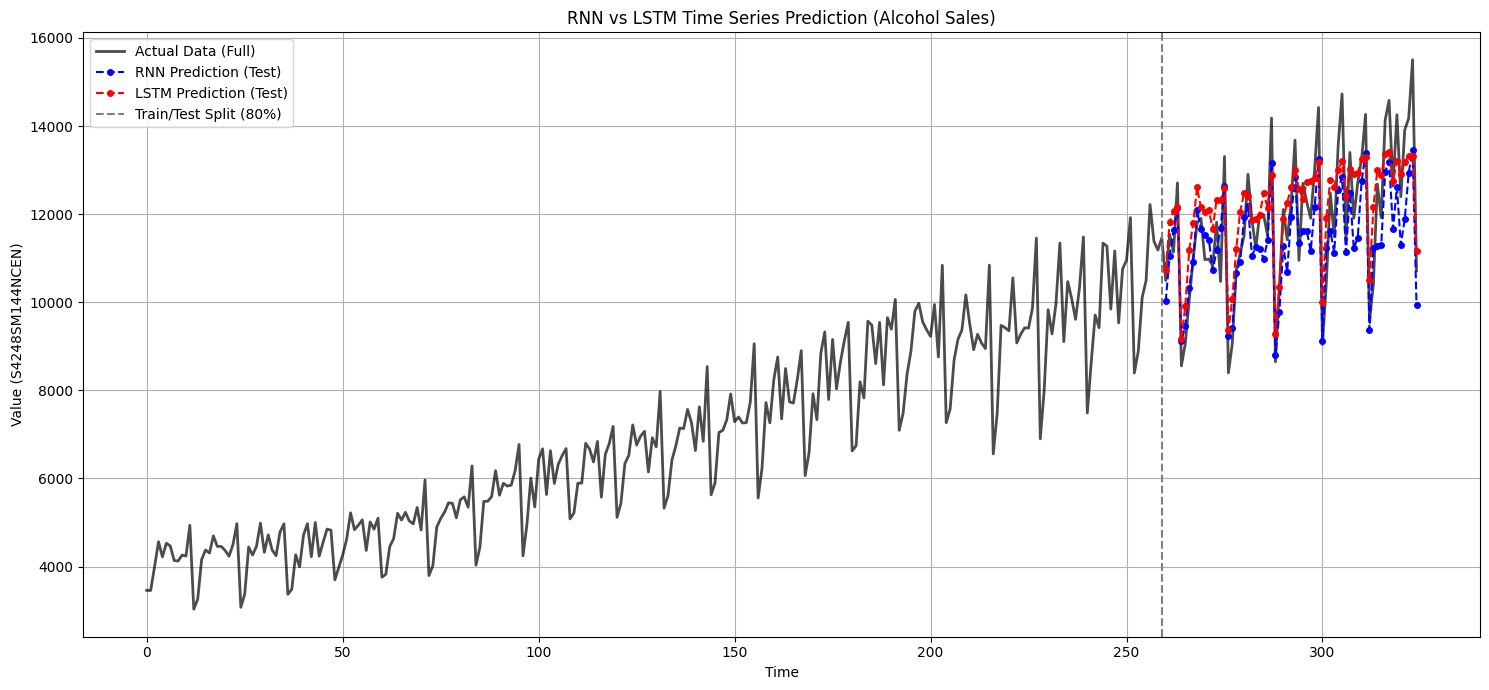

In [40]:
# -------------------------------------
# 8. 평가 및 시각화
# -------------------------------------
def get_predictions(model, loader, scaler):
    model.eval()
    # NameError 해결: predictions와 actuals 리스트를 초기화합니다.
    predictions = []
    actuals = []
    with torch.no_grad():
        for sequences, labels in loader:
            sequences, labels = sequences.to(device), labels.to(device)
            y_pred_scaled = model(sequences)

            # CPU로 데이터 이동 및 스케일 복원
            y_pred = scaler.inverse_transform(y_pred_scaled.cpu().numpy())
            y_actual = scaler.inverse_transform(labels.cpu().numpy())
            predictions.append(y_pred)
            actuals.append(y_actual)

    return np.array(predictions).flatten(), np.array(actuals).flatten()

# Test Loader를 사용하여 예측
pred_rnn, actual_rnn = get_predictions(model_rnn, test_loader, scaler)
pred_lstm, actual_lstm = get_predictions(model_lstm, test_loader, scaler)

# 3. MSE 및 RMSE 계산 (요청 사항)
# (스케일이 복원된) 실제값과 예측값으로 MSE/RMSE 계산
mse_rnn = mean_squared_error(actual_rnn, pred_rnn)
mse_lstm = mean_squared_error(actual_lstm, pred_lstm)
rmse_rnn = np.sqrt(mse_rnn)
rmse_lstm = np.sqrt(mse_lstm)

print("\n--- Test Set Performance (Original Scale) ---")
print(f"RNN  - MSE: {mse_rnn:.2f}, RMSE: {rmse_rnn:.2f}")
print(f"LSTM - MSE: {mse_lstm:.2f}, RMSE: {rmse_lstm:.2f}")


print("\n--- Test Set Predictions ---")
print(f"Actuals:\n{actual_lstm}")
print(f"RNN Preds:\n{pred_rnn}")
print(f"LSTM Preds:\n{pred_lstm}")


# 시각화
plt.figure(figsize=(15, 7))
plt.title("RNN vs LSTM Time Series Prediction (Alcohol Sales)")
plt.ylabel("Value (S4248SM144NCEN)")
plt.xlabel("Time")
plt.grid(True)

# 1. 전체 원본 데이터
plt.plot(data_raw, 'k-', label='Actual Data (Full)', linewidth=2.0, alpha=0.7)

# 2. Test 예측 (RNN)
# 예측 시작 인덱스 계산
test_pred_indices = np.arange(len(data_raw) - test_size, len(data_raw))
plt.plot(test_pred_indices, pred_rnn, 'b--o', label='RNN Prediction (Test)', markersize=4)

# 3. Test 예측 (LSTM)
plt.plot(test_pred_indices, pred_lstm, 'r--o', label='LSTM Prediction (Test)', markersize=4)

# 경계선
plt.axvline(x=split_index - 1, c='gray', linestyle='--', label='Train/Test Split (80%)')

plt.legend()
plt.tight_layout()
plt.show()